# Greedy search for best combination of channels

In [26]:
%matplotlib inline

#modeling
from sklearn.metrics import r2_score
from sklearn.preprocessing import Normalizer
from multichannel_svr.multichannel_svr import MultiChannelSVR, multichannel_KFoldCV
from multichannel_svr.theano_chi2 import theano_chi2
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.metrics import r2_score

#data
from sklearn.externals import joblib

#number
import numpy as np

#plotting
import matplotlib.pyplot as plt

#general
from time import time

In [5]:
#testing the kernel
X = np.random.random((1000,100))
X[0,0] = 0 #check for zeros in histograms
Y = np.random.random((1000,100))
t0 = time()
sk = chi2_kernel(X,X)
sk_time = time()-t0

t0 = time()
tk = theano_chi2(X,X, gamma = 10)
tk_time = time()-t0

print 'theano implementation {0} times faster'.format(sk_time/float(tk_time)),'\n'
print 'all theano kernel matrix elements within 1e-8 of sklearn value: {0}'.format(np.allclose(sk,tk))

theano implementation 1.07895627414 times faster 

all theano kernel matrix elements within 1e-8 of sklearn value: False


In [2]:
train_set = joblib.load('dataset/train_set_wlabels_it30.pkl')

In [3]:
#turn into multichannel tuple representation
channels = {}
channels['Trajectory'] = np.array(train_set.feature_dict['Trajectory'])
channels['MBHx'] = np.array(train_set.feature_dict['MBHx'])
channels['MBHy'] = np.array(train_set.feature_dict['MBHy'])
channels['HOG'] = np.array(train_set.feature_dict['HOG'])
channels['HOF'] = np.array(train_set.feature_dict['HOF'])

#labels
y_train = np.array(train_set.feature_dict['Label'])

In [7]:
#test
X_train = (channels['Trajectory'], channels['MBHx'], channels['MBHy'])
model_1 = MultiChannelSVR(num_channels=3, gamma_tuple=(1,5,5))
t0 = time()
model_1.fit(X_train, y_train)
print 'time taken {0}'.format(time()-t0)

time taken 39.6553139687


In [19]:
#set up channel lists
channels_original = ['Trajectory', 'MBHx', 'MBHy', 'HOG', 'HOF']
channels_added = []
channels_available = ['Trajectory', 'MBHx', 'MBHy', 'HOG', 'HOF']


#loop

finished=False #change to true when no improvement
best_score = 0
best_score_previous = 0
best_channels = []

while not finished:

    #loop through new channels
    for channel in channels_available:

        #add this channel to the channels already added
        current_channel_names = [channel] + channels_added #list of channel names

        #create the multichannel tuple
        current_X = []
        for name in current_channel_names:
            current_X.append(channels[name])
        current_X = tuple(current_X)

        #get the score of these chans
        #do a 9 element grid search on C=[.1,1,10], new_gamma=[.1,1,10]
        model = MultiChannelSVR(num_channels=len(current_X), param_dict={'C': 10}, gamma_tuple=None)
        score_list = multichannel_KFoldCV(model=model, X=current_X, y=y_train, n_folds=3, normalize=True, verbose=False)
        score = np.mean(score_list)
        print 'score for current channels {0}: {1}'.format(current_channel_names, score)

        if score > best_score:
            best_score = score
            channel_added = channel
            print 'best score beaten by adding {0} channel'.format(channel)
            
    if best_score_previous == best_score: #i.e. no change in this loop
        finished=True
        print 'finished!'
    else:
        best_score_previous = best_score #update the previous best score
        channels_added.append(channel_added)
        channels_available.remove(channel_added)
        print 'in this loop, added {0} channel'.format(channel_added)

score for current channels ['Trajectory']: 0.378180976648
best score beaten by adding Trajectory channel
score for current channels ['MBHx']: 0.444745735212
best score beaten by adding MBHx channel
score for current channels ['MBHy']: 0.434839126963
score for current channels ['HOG']: 0.453721083487
best score beaten by adding HOG channel
score for current channels ['HOF']: 0.445180034316
in this loop, added HOG channel
score for current channels ['Trajectory', 'HOG']: 0.487504808627
best score beaten by adding Trajectory channel
score for current channels ['MBHx', 'HOG']: 0.495913127643
best score beaten by adding MBHx channel
score for current channels ['MBHy', 'HOG']: 0.485238194445
score for current channels ['HOF', 'HOG']: 0.489196630521
in this loop, added MBHx channel
score for current channels ['Trajectory', 'HOG', 'MBHx']: 0.506231370876
best score beaten by adding Trajectory channel
score for current channels ['MBHy', 'HOG', 'MBHx']: 0.501053290191
score for current channels 

In [21]:
##ANALYSE ON TEST SET

In [22]:
#make training set
X_train = (channels['Trajectory'], channels['MBHx'], channels['MBHy'], channels['HOG'], channels['HOF'])
y_train = np.array(train_set.feature_dict['Label'])

In [24]:
#load the test set
test_set = joblib.load('dataset/test_set_wlabels_it30.pkl')

#turn into multichannel tuple representation
traj_feats_test = np.array(test_set.feature_dict['Trajectory'])
mbhx_feats_test = np.array(test_set.feature_dict['MBHx'])
mbhy_feats_test = np.array(test_set.feature_dict['MBHy'])
hog_feats_test = np.array(test_set.feature_dict['HOG'])
hof_feats_test = np.array(test_set.feature_dict['HOF'])
X_test = (traj_feats_test, mbhx_feats_test, mbhy_feats_test, hog_feats_test, hof_feats_test)

#labels
y_test = np.array(test_set.feature_dict['Label'])

In [27]:
X_train_norm, X_test_norm = [], []

for c_X_train, c_X_test in zip(X_train, X_test):

    #normalize
    normalizer = Normalizer(norm='l1')
    c_X_train = normalizer.fit_transform(c_X_train)
    c_X_test = normalizer.fit_transform(c_X_test)

    #add the values to this split's channel list
    X_train_norm.append(c_X_train)
    X_test_norm.append(c_X_test)

X_train_norm, X_test_norm = tuple(X_train_norm), tuple(X_test_norm)

In [29]:
mcsvr_final = MultiChannelSVR(num_channels=5, param_dict={'C':10})

In [30]:
#fit n predict
mcsvr_final.fit(X_train_norm, y_train)
y_pred = mcsvr_final.predict(X_test_norm)

In [34]:
#score 
score_final = r2_score(y_test, y_pred)
print 'final R^2 performance of SVR model: {0} \ncorrelation: {1}'.format(score_final, np.sqrt(score_final))

final R^2 performance of SVR model: 0.581170840545 
correlation: 0.762345617516


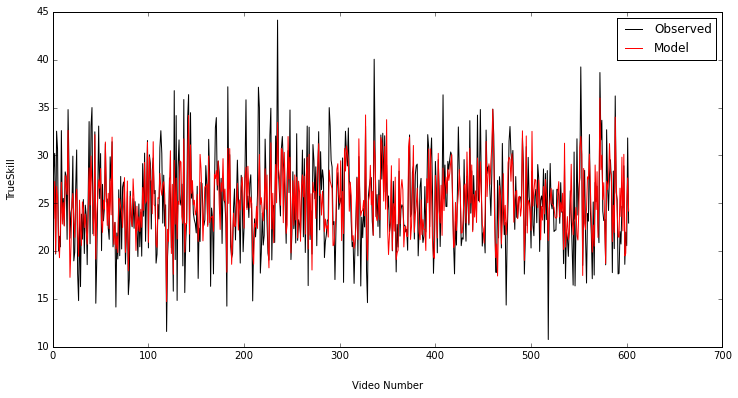

In [32]:
#plot
fig, ax = plt.subplots(figsize=(12,6))
X = range(len(y_pred))
y_tup = (y_test, y_pred)
labels=('Observed', 'Model')
colors = ('k', 'r')
for y, label, color in zip(y_tup, labels, colors):
    ax.plot(X, y, label=label, color=color)
ax.set_xlabel('Video Number', labelpad=20)
ax.set_ylabel('TrueSkill', labelpad=20)
leg = ax.legend()